In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
torch.cuda.empty_cache()

In [2]:
torch.__version__

'1.9.1'

In [3]:
train_dir = 'data/train'
test_dir = 'data/test'

In [4]:
os.listdir(train_dir)[:5]

['1_00695d43ffc3d286.jpg',
 '1_0071a139e38fe405.jpg',
 '1_00867630c33e0500.jpg',
 '1_01283048bd84fbf5.jpg',
 '1_015f426e437e233e.jpg']

In [5]:
os.listdir(test_dir)[:5]

['10_bf5a8bbca38d4c97.jpg',
 '10_dc05dcefc570d755.jpg',
 '11_4b581c074ee14f99.jpg',
 '11_9e113f0426d60aaf.jpg',
 '12_4a3f4936e9e233cb.jpg']

In [6]:
train_list = glob.glob(os.path.join(train_dir, '*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

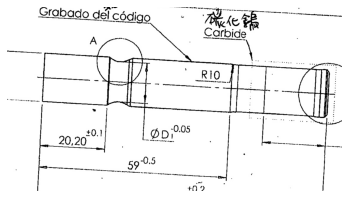

In [7]:
img = Image.open(train_list[2])
plt.imshow(img)
plt.axis('off')
plt.show()

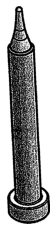

In [8]:
img = Image.open(test_list[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [10]:
label_dict = {}
with open('labels.csv', 'r', encoding='utf-8') as R:
    lines = R.readlines()
for line in lines:
    line = line.split('\n')[0].split(",")
    label_dict[line[0]] = int(line[1])
label_dict
    

{'10_bf5a8bbca38d4c97.jpg': 1,
 '10_dc05dcefc570d755.jpg': 1,
 '11_4b581c074ee14f99.jpg': 1,
 '11_9e113f0426d60aaf.jpg': 1,
 '12_4a3f4936e9e233cb.jpg': 1,
 '12_4b581c074ee14f99.jpg': 1,
 '12_9e113f0426d60aaf.jpg': 1,
 '12_bf5a8bbca38d4c97.jpg': 1,
 '13_9e113f0426d60aaf.jpg': 1,
 '13_bf5a8bbca38d4c97.jpg': 1,
 '14_9e113f0426d60aaf.jpg': 1,
 '14_bf5a8bbca38d4c97.jpg': 1,
 '15_9e113f0426d60aaf.jpg': 1,
 '15_dc05dcefc570d755.jpg': 1,
 '16_79e3e7a38ca4a32d.jpg': 1,
 '16_dc05dcefc570d755.jpg': 1,
 '16_dea27fa62416fbb4.jpg': 1,
 '17_4a3f4936e9e233cb.jpg': 1,
 '17_531f3c05dde112dd.jpg': 1,
 '17_9e113f0426d60aaf.jpg': 1,
 '1_00867630c33e0500.jpg': 1,
 '1_04792ff56b0eb66a.jpg': 1,
 '1_08438c38f7c796c5.jpg': 1,
 '1_0b43c30617054b36.jpg': 1,
 '1_123c2b3ad52add2a.jpg': 1,
 '1_193fdd653fccfb7a.jpg': 1,
 '1_1db3658f151852ca.jpg': 1,
 '1_21659114da515185.jpg': 1,
 '1_263a918e3149db16.jpg': 1,
 '1_27602c3c7474f0f4.jpg': 1,
 '1_2a173ad9fd450f30.jpg': 1,
 '1_2c7cf4b6aebf76d5.jpg': 1,
 '1_2cf71a0f24e2f91e

In [11]:
train_list[0].split('\\')[-1]

'1_00695d43ffc3d286.jpg'

In [12]:
# Dataset
class PartDataset(data.Dataset):
    
    def __init__(self, label_dict, file_list, transform=None, phase='train'):
        self.label_dict = label_dict
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        # Get Label
        label = self.label_dict[img_path.split('\\')[-1]]

        return img_transformed, label

In [13]:
size = 224
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
train_dataset = PartDataset(label_dict, train_list, transform=ImageTransform(size, mean, std), phase='train')
test_dataset = PartDataset(label_dict, test_list, transform=ImageTransform(size, mean, std), phase='test')

In [15]:
print('Operation Check')
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

Operation Check
torch.Size([3, 224, 224])
0


In [16]:
# DataLoader
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloader_dict = {'train': train_dataloader, 'test': test_dataloader}

# Operation Check
print('Operation Check')
batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

Operation Check
torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0])


In [17]:
use_pretrained = True
net = models.vgg11_bn(pretrained=False)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [18]:
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
print('Done')
net

Done


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)

In [20]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    net = net.to(device)
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'test']:
            
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    net.load_state_dict(best_model_wts)
    return net

In [21]:
num_epoch = 40
net = train_model(net, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/40
--------------------


C:\Users\ADMINI~1\AppData\Local\Temp\2/ipykernel_10928/1112937622.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.8203 Acc: 0.5400


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 1.0599 Acc: 0.4898
Epoch 2/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.7269 Acc: 0.6737


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.7115 Acc: 0.6786
Epoch 3/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.7742 Acc: 0.6725


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.6814 Acc: 0.6939
Epoch 4/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.5422 Acc: 0.7600


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5543 Acc: 0.7347
Epoch 5/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.4525 Acc: 0.7925


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5714 Acc: 0.7398
Epoch 6/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.4276 Acc: 0.8100


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5528 Acc: 0.6990
Epoch 7/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.4028 Acc: 0.8187


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5395 Acc: 0.6990
Epoch 8/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.4288 Acc: 0.8175


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.6286 Acc: 0.7194
Epoch 9/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.4218 Acc: 0.8100


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5530 Acc: 0.7347
Epoch 10/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.4013 Acc: 0.8425


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4753 Acc: 0.7347
Epoch 11/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.3572 Acc: 0.8438


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4623 Acc: 0.7704
Epoch 12/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.3665 Acc: 0.8350


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4844 Acc: 0.7347
Epoch 13/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.3453 Acc: 0.8500


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.6059 Acc: 0.7194
Epoch 14/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.3071 Acc: 0.8825


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5416 Acc: 0.8061
Epoch 15/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.3015 Acc: 0.8800


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.6472 Acc: 0.6786
Epoch 16/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.3428 Acc: 0.8613


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4397 Acc: 0.8367
Epoch 17/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.3516 Acc: 0.8525


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4800 Acc: 0.7857
Epoch 18/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.3457 Acc: 0.8638


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.3938 Acc: 0.8061
Epoch 19/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2982 Acc: 0.8762


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4459 Acc: 0.8265
Epoch 20/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2571 Acc: 0.9000


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4493 Acc: 0.8112
Epoch 21/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2461 Acc: 0.9012


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4920 Acc: 0.7449
Epoch 22/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2573 Acc: 0.9088


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.8022 Acc: 0.7500
Epoch 23/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2740 Acc: 0.8888


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.6817 Acc: 0.6837
Epoch 24/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2258 Acc: 0.9175


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.8089 Acc: 0.7551
Epoch 25/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2416 Acc: 0.9000


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4492 Acc: 0.8112
Epoch 26/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2356 Acc: 0.8950


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5547 Acc: 0.7704
Epoch 27/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2992 Acc: 0.8925


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.9793 Acc: 0.7398
Epoch 28/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2592 Acc: 0.9050


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.9715 Acc: 0.7194
Epoch 29/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2245 Acc: 0.9062


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4390 Acc: 0.8112
Epoch 30/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2487 Acc: 0.8912


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5797 Acc: 0.7653
Epoch 31/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2152 Acc: 0.9062


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4482 Acc: 0.8214
Epoch 32/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2081 Acc: 0.9313


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.7296 Acc: 0.7653
Epoch 33/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.1883 Acc: 0.9287


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5225 Acc: 0.7704
Epoch 34/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2161 Acc: 0.9200


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.7980 Acc: 0.6071
Epoch 35/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2054 Acc: 0.9150


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.6263 Acc: 0.7296
Epoch 36/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2246 Acc: 0.9300


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.3896 Acc: 0.8163
Epoch 37/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.1833 Acc: 0.9287


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.3813 Acc: 0.8163
Epoch 38/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.1786 Acc: 0.9325


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5755 Acc: 0.7908
Epoch 39/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.1853 Acc: 0.9325


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.4672 Acc: 0.8163
Epoch 40/40
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.2344 Acc: 0.8962


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.5643 Acc: 0.7959
Training complete in 9m 20s
Best val Acc: 0.836735


In [28]:
torch.save(net.state_dict(), 'C:\\Users\\Administrator\\Desktop\\partCNN\\checkpoint.pth')